# Hand Detector

In [1]:
import cv2

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from skimage import data, io, filters
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import hog 
from skimage.transform import resize

In [3]:
import pickle
import numpy as np
import pandas as pd

import glob
import random
import csv
from os import listdir
from os.path import isfile, join

In [4]:
from sklearn.naive_bayes import MultinomialNB,GaussianNB

In [5]:
import pandas as pd

In [6]:
import io

In [7]:
data_directory = '../data/hands/'

In [8]:
ls ../data/hands

user_10/ user_3/  user_4/  user_5/  user_6/  user_7/  user_9/


In [9]:
user_list = ['user_10', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_9']

In [10]:
def train_binary(train_list, data_directory):
    
    frame = pd.DataFrame()
    list_ = []
    for user in train_list:
        list_.append(pd.read_csv(data_directory + user + '/' + user + '_loc.csv', index_col=None, header=0))
    frame = pd.concat(list_)
    frame['side'] = frame['bottom_right_x']-frame['top_left_x']
    frame['hand'] = 1

    print ('Unique frames: %s' % frame.image.unique())

    imageset = getfiles(data_directory, frame.image.unique())

    #returns actual images and dataframe 
    return imageset, frame

In [11]:
#given a list of filenames return s a dictionary of images 
def getfiles(data_directory, filenames):
    dir_files = {}
    for x in filenames:
        filename = '%s/%s' % (data_directory, x)
        dir_files[x] = cv2.imread(filename)
    return dir_files

In [12]:
image_set, df = train_binary(user_list, data_directory) 

Unique frames: ['user_10/A0.jpg' 'user_10/A1.jpg' 'user_10/A2.jpg' ..., 'user_9/Y7.jpg'
 'user_9/Y8.jpg' 'user_9/Y9.jpg']


In [14]:
# image_set['user_10/A0.jpg']

In [15]:
df.hand.value_counts() # All hands

1    1680
Name: hand, dtype: int64

In [96]:
df.head(2)

,image,top_left_x,top_left_y,bottom_right_x,bottom_right_y,side,hand
0,user_10/A0.jpg,186,84,286,184,100,1
1,user_10/A1.jpg,186,84,286,184,100,1


In [16]:
#return hog of a particular image vector
def convertToGrayToHOG(imgVector):
    rgbImage = rgb2gray(imgVector)
    return hog(rgbImage)

In [17]:
def buildhandnothand_lis(frame, imgset):
    
    poslis =[]
    neglis =[]
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        
        dic = [0, 0]
        
        arg1 = [x_tl,y_tl,conf,side,side]
        poslis.append(convertToGrayToHOG(crop(imgset[nameimg],x_tl,x_tl+side,y_tl,y_tl+side)))
        while dic[0] <= 1 or dic[1] < 1:
            x = random.randint(0,320-side)
            y = random.randint(0,240-side) 
            crp = crop(imgset[nameimg],x,x+side,y,y+side)
            hogv = convertToGrayToHOG(crp)
            arg2 = [x,y, conf, side, side]
            
            z = overlapping_area(arg1,arg2)
            if dic[0] <= 1 and z <= 0.5:
                neglis.append(hogv)
                dic[0] += 1
            if dic[0]== 1:
                break
    label_1 = [1 for i in range(0,len(poslis)) ]
    label_0 = [0 for i in range(0,len(neglis))]
    label_1.extend(label_0)
    poslis.extend(neglis)
    return poslis,label_1

In [18]:
#takes returns cropped image 
def crop(img, x1, x2, y1, y2):
    crp=img[y1:y2, x1:x2]
    crp=resize(crp, ((128,128))) #resize
    return crp

In [19]:
#utility funtcion to compute area of overlap
def overlapping_area(detection_1, detection_2):
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

In [20]:
z = buildhandnothand_lis(df, image_set)

/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


bounding boxes:

In [21]:
z[0]

[array([ 0.06959381,  0.01554301,  0.02363114, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.06124146,  0.0163716 ,  0.02525483, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.09496679,  0.0164323 ,  0.02750747, ...,  0.        ,
         0.00031167,  0.        ]),
 array([ 0.06134381,  0.01375027,  0.02300072, ...,  0.00064264,
         0.00483669,  0.00259808]),
 array([ 0.0289681 ,  0.02990331,  0.0409313 , ...,  0.00500508,
         0.0192922 ,  0.05569076]),
 array([ 0.09559663,  0.0145166 ,  0.02161371, ...,  0.00178248,
         0.00097817,  0.04007515]),
 array([ 0.08493911,  0.02194829,  0.01851424, ...,  0.00565067,
         0.00236279,  0.06386312]),
 array([ 0.07191316,  0.01211939,  0.02393366, ...,  0.00356593,
         0.00949984,  0.10691469]),
 array([ 0.07640888,  0.01484057,  0.02443028, ...,  0.00319707,
         0.00077168,  0.06820894]),
 array([ 0.08351903,  0.0292667 ,  0.03094735, ...,  0.        ,
         0.        ,  0.  

labels:

In [22]:
from collections import Counter

In [23]:
Counter(z[1])

Counter({0: 1680, 1: 1680})

## Classifier

In [24]:
imageset, boundbox, hog_list, label_list = image_set, df, z[0], z[1] # Imageset, boundbox, hog_list,label_list Loaded

In [25]:
boundbox.iloc[0]

image             user_10/A0.jpg
top_left_x                   186
top_left_y                    84
bottom_right_x               286
bottom_right_y               184
side                         100
hand                           1
Name: 0, dtype: object

In [72]:
boundbox.iloc[0]['top_left_x']

186

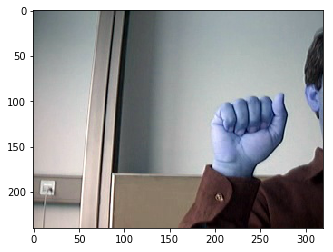

In [59]:
image = cv2.imread('../data/hands/user_10/A0.jpg')
plt.imshow(image)

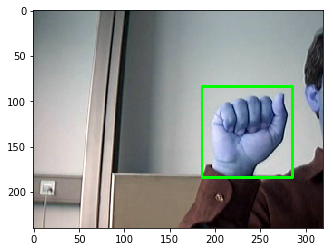

In [75]:
clone = image.copy()
rect = cv2.rectangle(clone, 
              (int(boundbox.iloc[0]['top_left_x']), int(boundbox.iloc[0]['top_left_y'])), 
              (int(boundbox.iloc[0]['bottom_right_x']), int(boundbox.iloc[0]['bottom_right_y'])), 
              (0, 255, 0), 2)
plt.imshow(rect)

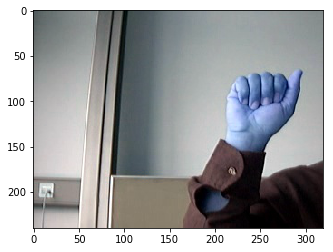

In [90]:
image = cv2.imread('../data/hands/user_10/A5.jpg')
plt.imshow(image)

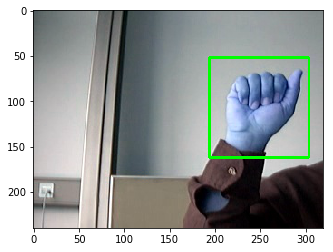

In [91]:
clone = image.copy()
rect = cv2.rectangle(clone, 
              (int(boundbox.iloc[5]['top_left_x']), int(boundbox.iloc[5]['top_left_y'])), 
              (int(boundbox.iloc[5]['bottom_right_x']), int(boundbox.iloc[5]['bottom_right_y'])), 
              (0, 255, 0), 2)
plt.imshow(rect)

In [79]:
clone.shape

(240, 320, 3)

In [26]:
boundbox.shape

(1680, 7)

In [27]:
len(hog_list)

3360

In [52]:
hog_list[0]

array([ 0.06959381,  0.01554301,  0.02363114, ...,  0.        ,
        0.        ,  0.        ])

In [78]:
hog_list[0].shape

(15876,)

In [87]:
hog_list[5].shape

(15876,)

In [97]:
15876 ** 0.5

126.0

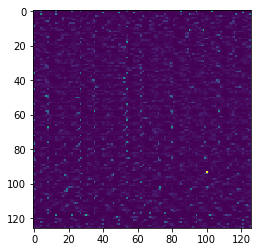

In [100]:
plt.imshow(hog_list[3000].reshape((126, 126)))

In [53]:
label_list[0]

1

In [55]:
label_list[3000]

0

In [28]:
#loads data for multiclass 
def get_data(user_list, img_dict, data_directory):
    X = []
    Y = []

    for user in user_list:
        user_images = glob.glob(data_directory+user+'/*.jpg')

        boundingbox_df = pd.read_csv(data_directory+user+'/'+user+'_loc.csv')
        
        for rows in boundingbox_df.iterrows():
            cropped_img = crop(img_dict[rows[1]['image']], rows[1]['top_left_x'], rows[1]['bottom_right_x'], rows[1]['top_left_y'], rows[1]['bottom_right_y'])
            hogvector = convertToGrayToHOG(cropped_img)
            X.append(hogvector.tolist())
            Y.append(rows[1]['image'].split('/')[1][0])
    return X, Y

In [29]:
len(user_list)

7

In [35]:
train_list = user_list[:-1] # user_list[:-1]

In [36]:
train_list, len(train_list)

(['user_10', 'user_3', 'user_4', 'user_5', 'user_6', 'user_7'], 6)

In [37]:
test_list = user_list[-1]

In [38]:
test_list

'user_9'

In [39]:
# Load data for the multiclass classification task
X_mul, Y_mul = get_data(train_list, image_set, data_directory)

In [40]:
len(X_mul)

1440

In [41]:
print "Performing HNM:"
no_of_false_positives = 1000000     # Initialise to some random high value

step_x = 32
step_y = 24

Performing HNM:


In [42]:
mnb  = MultinomialNB()

In [43]:
def cacheSteps(imgset, frame, step_x, step_y):
    # print "Cache-ing steps"
    list_dic_of_hogs = []
    dic = {}
    i = 0
    for img in frame.image:
        print img
        tupl = frame[frame['image']==img].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        i += 1 
        # if i%10 == 0:
        #     print "{0} images cached ".format(i)
        imaage = imgset[img]
        for x in range(0,320-side,step_x):
            for y in range(0,240-side,step_y):
                dic[str(img+str(x)+str(y))]=convertToGrayToHOG(crop(imaage,x,x+side,y,y+side))
    return dic  

In [46]:
cached_wind = cacheSteps(imageset, boundbox, step_x, step_y)

user_10/A0.jpg
user_10/A1.jpg
user_10/A2.jpg
user_10/A3.jpg
user_10/A4.jpg
user_10/A5.jpg
user_10/A6.jpg
user_10/A7.jpg
user_10/A8.jpg
user_10/A9.jpg
user_10/B0.jpg
user_10/B1.jpg
user_10/B2.jpg
user_10/B3.jpg
user_10/B4.jpg
user_10/B5.jpg
user_10/B6.jpg
user_10/B7.jpg
user_10/B8.jpg
user_10/B9.jpg
user_10/C0.jpg
user_10/C1.jpg
user_10/C2.jpg
user_10/C3.jpg
user_10/C4.jpg
user_10/C5.jpg
user_10/C6.jpg
user_10/C7.jpg
user_10/C8.jpg
user_10/C9.jpg
user_10/D0.jpg
user_10/D1.jpg
user_10/D2.jpg
user_10/D3.jpg
user_10/D4.jpg
user_10/D5.jpg
user_10/D6.jpg
user_10/D7.jpg
user_10/D8.jpg
user_10/D9.jpg
user_10/E0.jpg
user_10/E1.jpg
user_10/E2.jpg
user_10/E3.jpg
user_10/E4.jpg
user_10/E5.jpg
user_10/E6.jpg
user_10/E7.jpg
user_10/E8.jpg
user_10/E9.jpg
user_10/F0.jpg
user_10/F1.jpg
user_10/F2.jpg
user_10/F3.jpg
user_10/F4.jpg
user_10/F5.jpg
user_10/F6.jpg
user_10/F7.jpg
user_10/F8.jpg
user_10/F9.jpg
user_10/G0.jpg
user_10/G1.jpg
user_10/G2.jpg
user_10/G3.jpg
user_10/G4.jpg
user_10/G5.jpg
user_10/G6

user_4/I9.jpg
user_4/K0.jpg
user_4/K1.jpg
user_4/K2.jpg
user_4/K3.jpg
user_4/K4.jpg
user_4/K5.jpg
user_4/K6.jpg
user_4/K7.jpg
user_4/K8.jpg
user_4/K9.jpg
user_4/L0.jpg
user_4/L1.jpg
user_4/L2.jpg
user_4/L3.jpg
user_4/L4.jpg
user_4/L5.jpg
user_4/L6.jpg
user_4/L7.jpg
user_4/L8.jpg
user_4/L9.jpg
user_4/M0.jpg
user_4/M1.jpg
user_4/M2.jpg
user_4/M3.jpg
user_4/M4.jpg
user_4/M5.jpg
user_4/M6.jpg
user_4/M7.jpg
user_4/M8.jpg
user_4/M9.jpg
user_4/N0.jpg
user_4/N1.jpg
user_4/N2.jpg
user_4/N3.jpg
user_4/N4.jpg
user_4/N5.jpg
user_4/N6.jpg
user_4/N7.jpg
user_4/N8.jpg
user_4/N9.jpg
user_4/O0.jpg
user_4/O1.jpg
user_4/O2.jpg
user_4/O3.jpg
user_4/O4.jpg
user_4/O5.jpg
user_4/O6.jpg
user_4/O7.jpg
user_4/O8.jpg
user_4/O9.jpg
user_4/P0.jpg
user_4/P1.jpg
user_4/P2.jpg
user_4/P3.jpg
user_4/P4.jpg
user_4/P5.jpg
user_4/P6.jpg
user_4/P7.jpg
user_4/P8.jpg
user_4/P9.jpg
user_4/Q0.jpg
user_4/Q1.jpg
user_4/Q2.jpg
user_4/Q3.jpg
user_4/Q4.jpg
user_4/Q5.jpg
user_4/Q6.jpg
user_4/Q7.jpg
user_4/Q8.jpg
user_4/Q9.jpg
user_4

user_6/U5.jpg
user_6/U6.jpg
user_6/U7.jpg
user_6/U8.jpg
user_6/U9.jpg
user_6/V0.jpg
user_6/V1.jpg
user_6/V2.jpg
user_6/V3.jpg
user_6/V4.jpg
user_6/V5.jpg
user_6/V6.jpg
user_6/V7.jpg
user_6/V8.jpg
user_6/V9.jpg
user_6/W0.jpg
user_6/W1.jpg
user_6/W2.jpg
user_6/W3.jpg
user_6/W4.jpg
user_6/W5.jpg
user_6/W6.jpg
user_6/W7.jpg
user_6/W8.jpg
user_6/W9.jpg
user_6/X0.jpg
user_6/X1.jpg
user_6/X2.jpg
user_6/X3.jpg
user_6/X4.jpg
user_6/X5.jpg
user_6/X6.jpg
user_6/X7.jpg
user_6/X8.jpg
user_6/X9.jpg
user_6/Y0.jpg
user_6/Y1.jpg
user_6/Y2.jpg
user_6/Y3.jpg
user_6/Y4.jpg
user_6/Y5.jpg
user_6/Y6.jpg
user_6/Y7.jpg
user_6/Y8.jpg
user_6/Y9.jpg
user_7/A0.jpg
user_7/A1.jpg
user_7/A2.jpg
user_7/A3.jpg
user_7/A4.jpg
user_7/A5.jpg
user_7/A6.jpg
user_7/A7.jpg
user_7/A8.jpg
user_7/A9.jpg
user_7/B0.jpg
user_7/B1.jpg
user_7/B2.jpg
user_7/B3.jpg
user_7/B4.jpg
user_7/B5.jpg
user_7/B6.jpg
user_7/B7.jpg
user_7/B8.jpg
user_7/B9.jpg
user_7/C0.jpg
user_7/C1.jpg
user_7/C2.jpg
user_7/C3.jpg
user_7/C4.jpg
user_7/C5.jpg
user_7

In [47]:
def do_hardNegativeMining(cached_window, frame, imgset, model, step_x, step_y):   
    lis = []
    no_of_false_positives = 0
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        
        dic = [0, 0]
        
        arg1 = [x_tl,y_tl,conf,side,side]
        for x in range(0,320-side,step_x):
            for y in range(0,240-side,step_y):
                arg2 = [x,y,conf,side,side]
                z = overlapping_area(arg1,arg2)
                
                prediction = model.predict([cached_window[str(nameimg)+str(x)+str(y)]])[0]

                if prediction == 1 and z<=0.5:
                    lis.append(cached_window[str(nameimg)+str(x)+str(y)])
                    no_of_false_positives += 1
    
    label = [0 for i in range(0,len(lis))]
    return lis,label, no_of_false_positives

In [50]:
# frame - bounding boxes-df; yn_df - yes_or_no df
def improve_Classifier_using_HNM(hog_list, label_list, frame, imgset, threshold=50, max_iterations=25): 
    
    # ...
    i = 0

    while True:
        i += 1
        model = mnb.partial_fit(hog_list, label_list, classes = [0, 1])

        ret = do_hardNegativeMining(cached_wind, frame, imgset, model, step_x=step_x, step_y=step_y)
        
        hog_list = ret[0]
        label_list = ret[1]
        no_of_false_positives = ret[2]
        
        if no_of_false_positives == 0:
            return model
        
        print "Iteration {0} - No_of_false_positives: {1}".format(i, no_of_false_positives) 
        
        if no_of_false_positives <= threshold:
            return model
        
        if i>max_iterations:
             return model

In [101]:
# handDetector = improve_Classifier_using_HNM(hog_list, 
#                                             label_list, 
#                                             boundbox, 
#                                             image_set, 
#                                             threshold=40, 
#                                             max_iterations=35)